In [65]:
import pandas as pd 
import os 
import re
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.font_manager import FontProperties
from sqlalchemy import create_engine, exc
from zoneinfo import ZoneInfo
import pymysql

In [66]:
username_sql = os.getenv("ANDY_USERNAME_SQL")
password_sql = os.getenv("ANDY_PASSWORD_SQL")
# server = "host.docker.internal:3306"  #docker用
server = "localhost:3306"
db_name = "group2_db"
with create_engine(f"mysql+pymysql://{username_sql}:{password_sql}@{server}/{db_name}",).connect() as conn:
    sql = """select * from mrt_station"""
    df_station = pd.read_sql(sql=sql,con=conn)

In [67]:
path = os.path.join(os.getcwd(),"data","MRT","mrt_realtime_crowded.csv")
df = pd.read_csv(path)
df

,mrt_station_id,mrt_station_name,line_type,direction,cart1,cart2,cart3,cart4,cart5,cart6,update_time
0,BL01,頂埔,BL,上行,1,1,1,1,1.0,1.0,2024-05-04 11:16:49
1,BL01,頂埔,BL,上行,1,1,1,1,1.0,1.0,2024-05-04 11:26:27
2,BL01,頂埔,BL,上行,1,1,1,1,1.0,1.0,2024-05-04 11:35:25
3,BL01,頂埔,BL,上行,1,1,1,1,1.0,1.0,2024-05-04 11:37:42
4,BL01,頂埔,BL,上行,1,1,1,1,1.0,1.0,2024-05-04 11:49:09
...,...,...,...,...,...,...,...,...,...,...,...
128761,R28,NaN,R,下行,1,1,1,1,1.0,1.0,2024-05-08 23:22:59
128762,R28,NaN,R,下行,1,1,1,1,1.0,1.0,2024-05-08 23:44:43
128763,R28,NaN,R,下行,1,1,1,1,1.0,1.0,2024-05-08 23:48:11
128764,R28,NaN,R,下行,1,1,1,1,1.0,1.0,2024-05-08 23:54:09


In [68]:
df['update_time'] = pd.to_datetime(df['update_time'])

In [69]:
df["date"] = df["update_time"].dt.date
df["hour"] = df["update_time"].dt.hour

In [70]:
df['update_time_hour'] = df['update_time'].dt.floor('h')

In [71]:
df_station.to_csv("mrt_station.csv",index=False,encoding="utf-8-sig")

In [72]:
df_station.columns

Index(['mrt_station_id', 'line_type', 'mrt_station_name', 'station_en',
       'station_address', 'lat', 'lon', 'city_code', 'district',
       'bike_allow_on_holiday', 'update_time'],
      dtype='object')

In [73]:
df = df.merge(df_station.loc[:,['mrt_station_id', 'mrt_station_name', 'lat', 'lon']],
         on="mrt_station_id",how="left",suffixes=["_l","_r"])

In [74]:
df["mrt_station_name_l"] = df["mrt_station_name_r"]
df.drop(columns=["mrt_station_name_r"],inplace=True)
df.rename(columns={"mrt_station_name_l":"mrt_station_name"},inplace=True)

In [75]:
df.columns

Index(['mrt_station_id', 'mrt_station_name', 'line_type', 'direction', 'cart1',
       'cart2', 'cart3', 'cart4', 'cart5', 'cart6', 'update_time', 'date',
       'hour', 'update_time_hour', 'lat', 'lon'],
      dtype='object')

In [61]:
dfmelt = df.melt(id_vars=['mrt_station_id', 'mrt_station_name_l', 'line_type', 'direction', 'update_time_hour'], 
              value_vars=['cart1', 'cart2', 'cart3', 'cart4', 'cart5', 'cart6'],
              var_name="cart", 
              value_name='value')

In [78]:
df_groupby = pd.DataFrame(dfmelt.groupby(['mrt_station_id', 
                                          'mrt_station_name_l', 
                                          'line_type', 'direction',
                                          'update_time_hour','cart'])['value'].mean())

In [81]:
df_groupby.reset_index(drop=False,inplace=True)

In [86]:
df_groupby.to_csv("mrt_realtime_crowded_groupby.csv",index=False,encoding="utf-8-sig")

In [85]:
df_groupby.sort_values(by=["value"],ascending=False)

,mrt_station_id,mrt_station_name_l,line_type,direction,update_time_hour,cart,value
75616,O13,台北橋,O,上行,2024-05-06 18:00:00,cart5,4.0
10593,BL12,台北車站,BL,上行,2024-05-07 09:00:00,cart4,4.0
10087,BL11,西門,BL,下行,2024-05-06 18:00:00,cart2,4.0
10088,BL11,西門,BL,下行,2024-05-06 18:00:00,cart3,4.0
75613,O13,台北橋,O,上行,2024-05-06 18:00:00,cart2,4.0
...,...,...,...,...,...,...,...
45515,BR24,南港展覽館,BR,下行,2024-05-08 22:00:00,cart6,NaN
45520,BR24,南港展覽館,BR,下行,2024-05-08 23:00:00,cart5,NaN
45521,BR24,南港展覽館,BR,下行,2024-05-08 23:00:00,cart6,NaN
45526,BR24,南港展覽館,BR,下行,2024-05-09 00:00:00,cart5,NaN


In [38]:
df.loc[df["mrt_station_name"].isna(),]
df.loc[df["mrt_station_id"]=="BL99",]

,mrt_station_id,mrt_station_name,line_type,direction,cart1,cart2,cart3,cart4,cart5,cart6,update_time,date,hour,update_time_hour
21420,BL99,NaN,BL,下行,1,1,1,1,1.0,1.0,2024-05-08 09:00:38,2024-05-08,9,2024-05-08 09:00:00


In [35]:
df.columns

Index(['mrt_station_id', 'mrt_station_name', 'line_type', 'direction', 'cart1',
       'cart2', 'cart3', 'cart4', 'cart5', 'cart6', 'update_time', 'date',
       'hour', 'update_time_hour'],
      dtype='object')

In [29]:
df.groupby([])

,mrt_station_id,mrt_station_name,line_type,direction,cart1,cart2,cart3,cart4,cart5,cart6,update_time,date,hour
0,BL01,頂埔,BL,上行,1,1,1,1,1.0,1.0,2024-05-04 11:16:49,2024-05-04,11
1,BL01,頂埔,BL,上行,1,1,1,1,1.0,1.0,2024-05-04 11:26:27,2024-05-04,11
2,BL01,頂埔,BL,上行,1,1,1,1,1.0,1.0,2024-05-04 11:35:25,2024-05-04,11
3,BL01,頂埔,BL,上行,1,1,1,1,1.0,1.0,2024-05-04 11:37:42,2024-05-04,11
4,BL01,頂埔,BL,上行,1,1,1,1,1.0,1.0,2024-05-04 11:49:09,2024-05-04,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...
128761,R28,NaN,R,下行,1,1,1,1,1.0,1.0,2024-05-08 23:22:59,2024-05-08,23
128762,R28,NaN,R,下行,1,1,1,1,1.0,1.0,2024-05-08 23:44:43,2024-05-08,23
128763,R28,NaN,R,下行,1,1,1,1,1.0,1.0,2024-05-08 23:48:11,2024-05-08,23
128764,R28,NaN,R,下行,1,1,1,1,1.0,1.0,2024-05-08 23:54:09,2024-05-08,23


In [5]:
melted_data = df.melt(id_vars=['mrt_station_id', 'mrt_station_name', 'line_type', 'direction', 'update_time'],
                        value_vars=['cart1', 'cart2', 'cart3', 'cart4', 'cart5', 'cart6'],
                        var_name='car', value_name='congestion')
melted_data

,mrt_station_id,mrt_station_name,line_type,direction,update_time,car,congestion
0,BL01,頂埔,BL,上行,2024-05-04 11:16:49,cart1,1.0
1,BL01,頂埔,BL,上行,2024-05-04 11:26:27,cart1,1.0
2,BL01,頂埔,BL,上行,2024-05-04 11:35:25,cart1,1.0
3,BL01,頂埔,BL,上行,2024-05-04 11:37:42,cart1,1.0
4,BL01,頂埔,BL,上行,2024-05-04 11:49:09,cart1,1.0
...,...,...,...,...,...,...,...
772591,R28,NaN,R,下行,2024-05-08 23:22:59,cart6,1.0
772592,R28,NaN,R,下行,2024-05-08 23:44:43,cart6,1.0
772593,R28,NaN,R,下行,2024-05-08 23:48:11,cart6,1.0
772594,R28,NaN,R,下行,2024-05-08 23:54:09,cart6,1.0


In [21]:
plt.rc('font', family='Microsoft JhengHei')

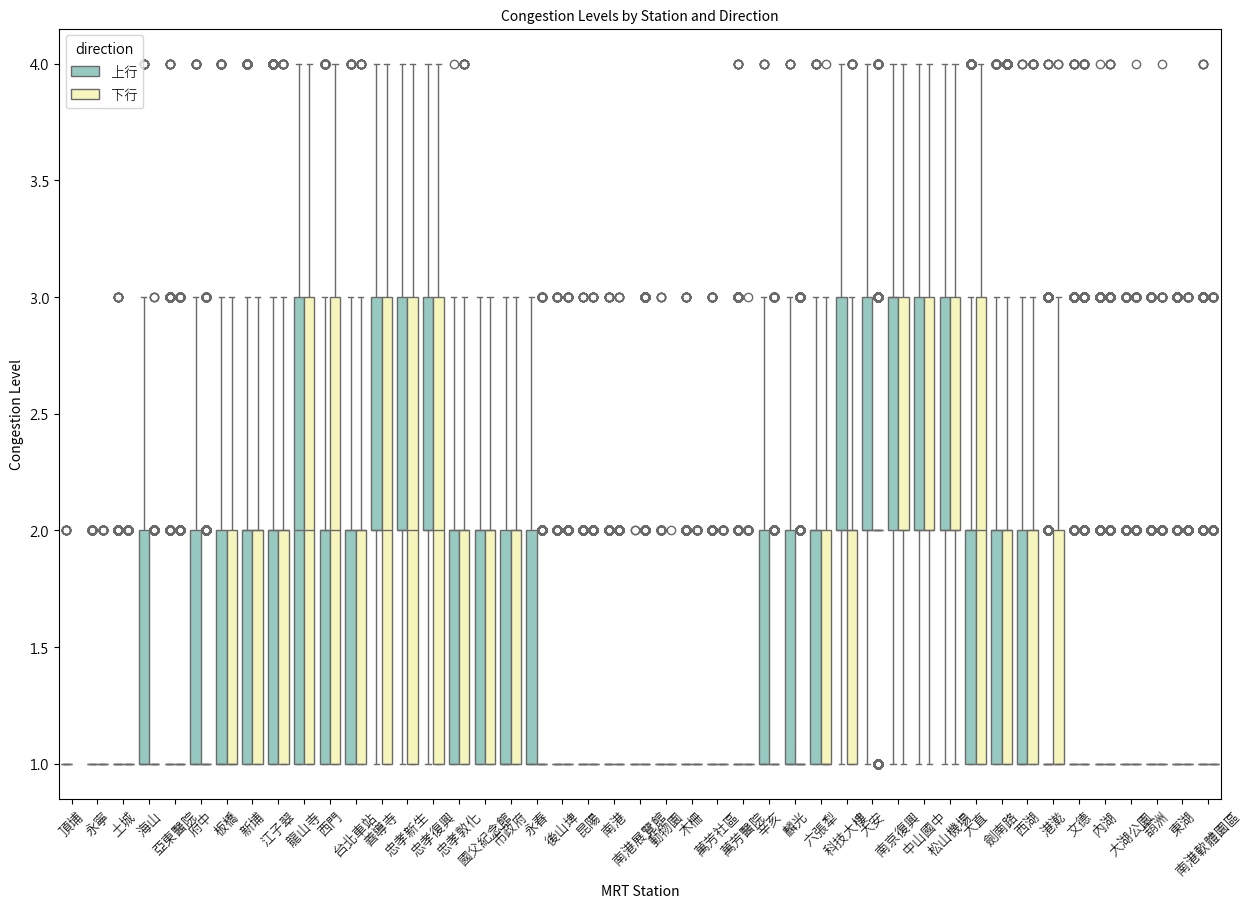

In [22]:
melted_data.dropna(subset=['congestion'], inplace=True)

# Create a new figure with a larger size
plt.figure(figsize=(15, 10))
font = FontProperties(fname="NotoSansTC-Regular.otf")
# Create a boxplot
sns.boxplot(x='mrt_station_name', y='congestion', hue='direction', data=melted_data, palette='Set3')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Set titles and labels

plt.title('Congestion Levels by Station and Direction',fontproperties=font)
plt.xlabel('MRT Station',fontproperties=font)
plt.ylabel('Congestion Level',fontproperties=font)

# Show the plot
plt.show()


In [ ]:
def count(stationname)